In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=1)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 26.92 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.15.0
Using accelerate v0.25.0
Using sentencepiece v0.1.99
Using sacremoses v0.1.1
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


# 1. 트랜스포머 소개
##### 구글에서 2017년 시퀀스 모델링을 위한 새로운 신경망인 트랜스포머(Transformer)란 아키텍처를 제안했다. 해당 아키텍처는 기존 순환 신경망(RNN)에 비해 품질과 비용 측면에서 더 뛰어났다.
##### 동시에 효율적인 전이 학습 방법인 ULMFiT가 매우 큰 말뭉치에서 LSTM 신경망을 훈련해 매우 적은 양의 레이블링된 데이터로도 높은 구준의 텍스트 분류 모델을 만들어낼수 있었다.
##### 이런 트랜스포머의 발전이 GPT와 BERT를 릴리스할 수 있게 되었다.
##### 해당 모델들은 트랜스포머 아키텍처와 비지도 학습을 결합해 모델을 밑바닥부터 훈련할 필요가 없게 하여 NLP 벤치마크에서 큰 차이로 기록을 경신했다.
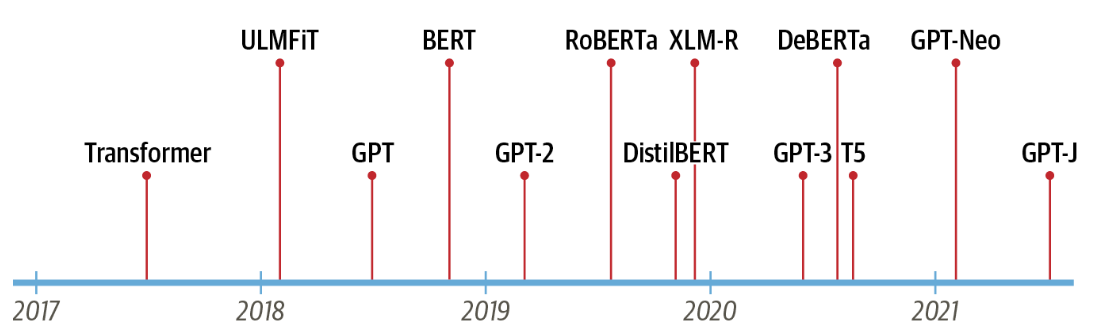
##### 트랜스포머의 새로운 점을 이해할려면 아래 세 가지 점을 이해해야한다.
##### - 인코더 - 디코더 프레임워크
##### - 어텐션 메커니즘
##### - 전이 학습
##### 이렇게 트랜스포머의 기초가 되는 핵심 개념을 소개하고 어떻게 작업이 돌아가는 지 확인한다. 그리고 마지막으로 허깅페이스 생태계의 도구와 라이브러리를 알아볼 것이다.

## 1.1 인코더-디코더 프레임워크
##### 트랜스포머가 등장하기 전, LSTM 같은 순환 신경망 구조가 최고 수준의 성능을 달성했다.
##### 순환 신경망 구조에는 정보를 한 스텝에서 다음 스텝으로 전파하도록 네트워크에 피드백 루프가 포함된다. 이런 구조는 텍스트와 같은 순차 데이터를 모델링하는데 이상적이다.
##### 아래 그림을 보면 RNN은 입력을 받아 네트워크를 통과시킨 후 **은닉 상태**라는 벡터를 출력한다. 동시에 출력된 정보를 피드백 루프로 보내 자기 자신을 다시 입력한다. 이런 과정을 거쳐 RNN은 출력한 정보의 일부를 다음 스텝에 사용하게 된다.
##### 즉, RNN은 각 스텝에서 상태에 대한 정보를 시퀀스의 다음 작업으로 전달한다. 이런 식으로 이전 스텝의 정보를 추적하고 이를 사용해 예측을 만든다.
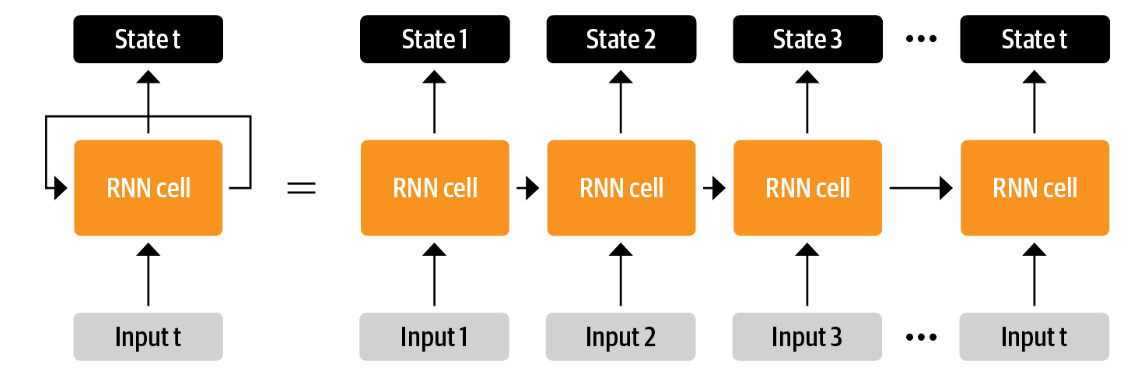


##### RNN은 단어 시퀀스를 한 언어에서 다른 언어로 매핑하는 기계 번역 시스템을 개발할 때 중요한 역할을 했다. 이런 종류의 작업은 대게 **인코더-디코더** 또는 **시퀀스-투-시퀀스** 구조로 처리하며 입력과 출력이 임의의 길이를 가진 시퀀스일 때 잘 맞다.
##### 인코더는 입력 시퀀스의 정보를 **마지막 은닉 상태**라고도 부르는 수치 표현으로 인코딩한다. 그다음 이 상태가 디코더로 전달되어 출력 시퀀스가 생성된다.
##### 아래 그림에서 영어 문장 "Transformers are great!"을 은닉 상태 벡터로 인코딩한 다음, 이를 디코딩해 독일어 문장 "Transformer sind grossartig!"으로 만든 한 쌍의 RNN이다.
##### 입력 단어는 순차적으로 인코더에 주입되고 출력 단어는 위에서 아래 방향으로 한 번에 하나씩 생성된다.
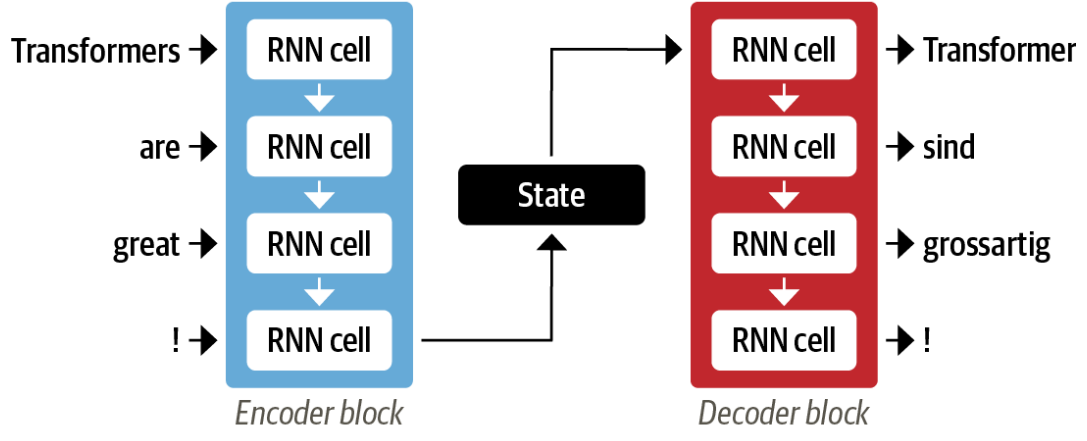

##### 간결하지만, 이 구조는 인코더의 마지막 은닉 상태가 **정보 병목**이 된다는 약점이 있다.
##### 디코더는 인코더의 마지막 은닉 상태만을 참조해 출력을 만들므로 여기에 전체 시퀀스의 의미가 담겨있어야 한다. 시퀀스가 긴 경우, 모든 것을 고정된 하나의 표현으로 압축하는 과정에서 시작 부분의 정보가 손실될 가능성 있어 취약하다
##### 다행히 디코더가 인코더의 모든 은닉 상태에 접근해 이 병목을 제거한다. 이런 일반적인 메커니즘을 어텐션이라고 한다. 이것이 최신 신경망 구조의 핵심 구성 요소이다.

## 1.2 어텐션 매커니즘
##### 어텐션은 입력 시퀀스에서 은닉 상태를 만들지 않고 스텝마다 인코더에서 디코더가 참고할 은닉 상태를 출력한다는 주요 개념을 기초한다.
##### 하지만 모든 상태를 동시에 사용하려면 디코더에 많은 입력이 발생하므로 어떤 상태를 먼저 사용할 지 우선순위를 정하는 매커니즘이 필요하다.
##### 디코더가 모든 디코딩 타입 스텝마다 인코더의 각 상태에 다른 가중치 또는 '어텐션'을 할당한다.
##### 아래 그림에서 어텐션은 출력 시퀀스에 있는 두 번째 토큰을 예측하는 역할을 한다.
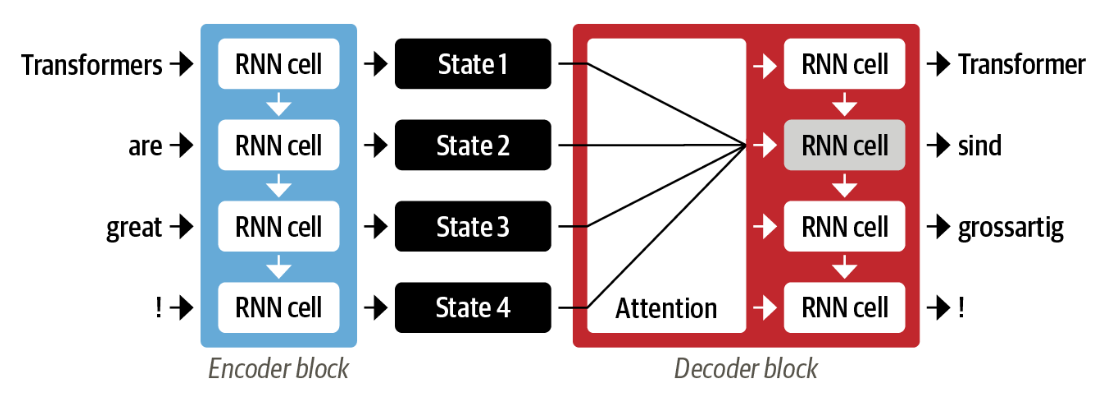
##### 어텐션 기반 모델은 타입스텝마다 가장 많이 관련된 입력 토큰에 초점을 맞추므로 번역 문장에 있는 단어와 원 문장에 있는 단어의 복잡한 정렬 문제를 학습한다.
##### 예를 들어, 아래 사진은 영어-프랑스어 변역 모델의 어텐션 가중치를 보여준다. 여기서 각 픽셀은 각각의 가중치를 나타낸다. 'zone'과 'Area'를 디코더가 어떻게 올바르게 정렬하는지 보여준다.
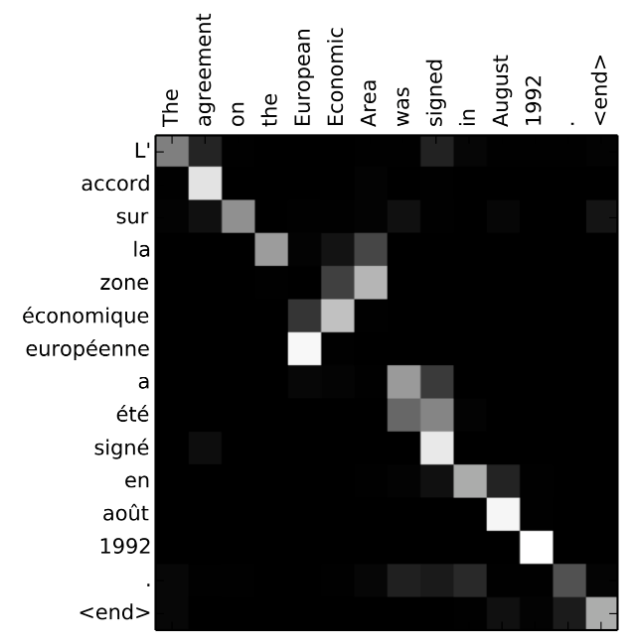

##### 어텐션으로 번역이 한결 좋아졌지만, 인코더와 디코더에 사용하는 순환 모델의 단점은 여전히 존재한다.
##### 태생적으로 순차적으로 수행되며 입력 시퀀스를 전체에 걸쳐 병렬화할 수 없다.
##### 그래서, 순환을 모두 없애고 **셀프 어텐션**이라는 특별한 형태의 어텐션에 의지한다.
##### 기본적으로 신경망의 같은 층에 있는 모든 상태에 대해서 어텐션을 작동하는 방식이다.
##### 아래 그림에 있는 인코더와 디코더는 각각 셀프 어텐션이 있다. 어텐션의 출력은 피드 푸워드 신경망(FFNN)에 주입된다. 이 구조는 순환 모델보다 더 빠르게 훈련하며 최근 NLP 분야에서 대단한 혁신이다.
#####  피드 푸워드 신경망 : 노드 간의 연결이 순환을 형성하지 않는 인공 신경망
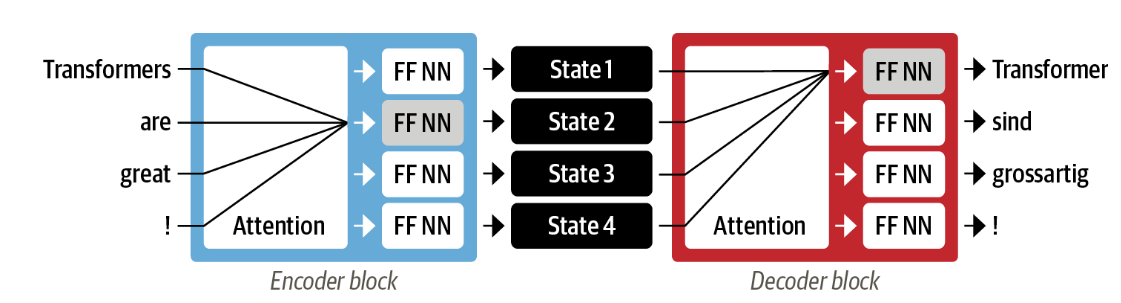

##### 트랜스포머 원래 논문에서는 처음부터 대량의 데이터로 구성된 대규모 말뭉치에서 번역 모델울 훈련했다.
##### 하지만, 많은 실용적인 NLP 애플리케이션이 모델 훈련에 사용할 레이블린된 대규모 텍스트 데이터를 구할 수 없다.
##### 그래서 전이 학습 사용한다.

## 1.3 NLP의 전이 학습
##### 요즘 컴퓨터 비전(CV)에서는 전이 학습을 사용해 ResNet 같은 합성곱 신경망을 한 작업에서 훈련한 다음 새로운 작업에 적용하거나 미세 튜닝을 한다. 이를 통해 신경망은 원래 작업에서 학습한 지식을 공유한다.
##### 구조적으로 볼 때 모델은 바디와 헤드로 나뉜다. 바디의 가중치는 훈련하는 동안 원래 도메인에서 다양한 특성을 학습하고, 이 가중치를 사용해 새로운 작업을 위한 모델을 초기화한다.
##### 전통적인 지도 학습과 비교하여 적은 양의 레이블 데이터로 높은 품질의 모델을 만든다.
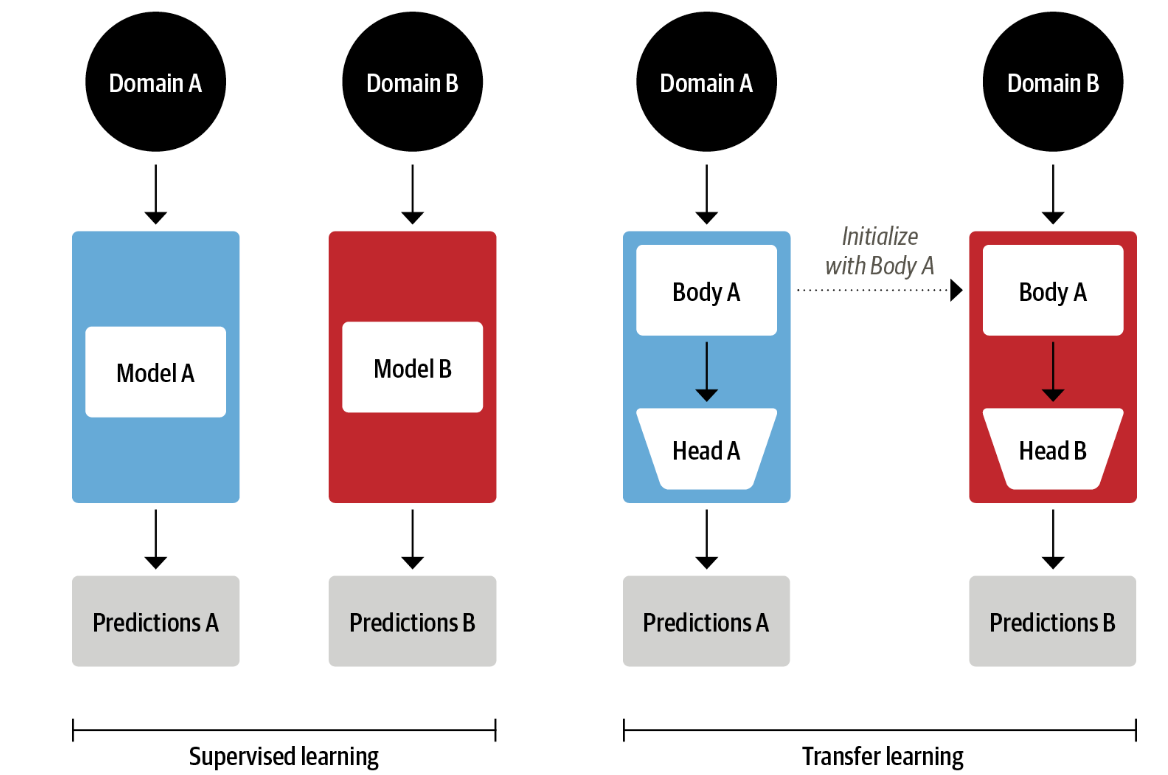

##### 컴퓨터 비전에서는 먼저 이미지가 수백만 개인 ImageNet 같은 대규모 데이터셋에서 모델을 훈련한다. 이 과정이 **사전 훈련**이며, 모델에게 에지나 색깔 같은 기본적인 이미지 특징을 가르치는 것이다.
##### 그 다음 사전 훈련된 모델을 후속 작업에서 미세 튜닝할 수 있다. 미세 튜닝한 모델은 일반적으로 처음부터 동일한 양의 레이블링된 데이터에서 훈련하는 지도 학습 모델보다 정확도가 더 높다.
##### OpenAI 연구원들이 감성 분류 작업에 비지도 사전 훈련에서 추출한 특성을 사용해 높은 성능을 얻으며 소개된 방식이다. ULMFiT는 다양한 작업에 사전 훈련된 LSTM 모델을 적용한다.
##### ULMFiT는 세 개의 주요 단계로 구성된다.

### 사전 훈련
##### 초기 훈련의 목표는 간단하다. 이전 단어를 바탕으로 다음 단어를 예측하는 것이다. 이 작업을 **언어 모델링**이라 한다.
##### 편리하게도 이 작업은 레이블링된 데이터가 필요하지 않으므로 풍부한 텍스트를 활용한다.(위키피디아)


### 도메인 적용
##### 언어 모델을 대규모 말뭉치에서 사전 훈련한 후, 다음 단계로 도메인 내 말뭉치에 적응시킨다. 여전히 언어 모델링을 사용하지만 이제 모델은 타킷 말뭉치에 있는 다음 단어를 예측한다.


### 미세튜닝
##### 이 단계에서 언어 모델을 타깃 작업을 위한 분류 층과 미세 튜닝한다.
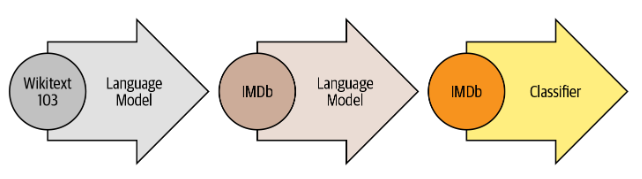

##### 2018년 셀프 어텐션과 전이 학습을 결합한 두 개의 트랜스포머 모델이 릴리스 되었다.
### GPT
##### 트랜스포머 아키텍처의 디코더 부분만 사용하고 ULMFiT 같은 언어 모델링 방법을 사용한다.

### BRET
##### 트랜스포머 아키텍처의 인코더 부분을 사용하고 **마스크드 언어 모델링**이라는 특별한 형태의 언어 모델링을 사용한다. 마스크드 언어 모델링의 목표는 텍스트에서 랜덤하게 마스킹된 단어를 예측하는 것이다.
##### 예를 들어, 'I looked at my [MASK] and saw that [MASK] was late'라는 문장에서 모델은 [MASK]로 마스킹된 단어에 대해 가장 가능성이 높은 후보를 예측한다.

##### GPT와 BERT는 다양한 NLP 벤치마크에서 기록을 새롭게 경신하며 트랜스포머 시대를 열었다.
##### 하지만 연구실마다 호환되지 않는 프레임워크를 사용해 모델을 릴리스했고, 자신의 애플리케이션에 포팅하기가 쉽지 않다.
##### 그래서 허깅페이스 트랜스포머스가 릴리스 되면서 단일화된 API로 쉽게 사용할 수 있게 되었다.

## 1.4 허깅페이스 트랜스포머스